
**Processing of Clapping Motion Data Collected from Chest-Mounted Accelerometers at MusicLab Copenhagen Concert**

> Ahmet Emin Memis
> ahmeteminmemis@gmail.com
> 07.02.2022



During the MusicLab concert, audience members placed mobile phones on their chests which allowed us to collect their motion data while they are experiencing the concert.

Throuhout the concert, 15 clappings occurred either after speeches or musical pieces or at the end of the concert. This notebook processes the motion data of 75 participants during these clapping sections.

# Dependencies

In [1]:
# dependencies

import os
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

pd.options.mode.chained_assignment = None

In [2]:
# functions

def rms_signal(data, window_size, shift):
  # data is pandas Series of signal
  # function to calculate root mean square using a scrolling window.
  i = int(window_size/2)
  l = data.shape[0]
  rms_y = [np.nan]*l

  while True:
    if i >= l:
      break

    if (i >= window_size/2) and (l-i >= window_size/2):
      in_window  = int(i-window_size/2)
      out_window = int(i+window_size/2)

      data_rms = data.iloc[in_window:out_window]
      if data_rms.isna().sum() < (len(data_rms)):
        data_rms = data_rms.dropna()
      rms_value = math.sqrt(sum([i*i for i in data_rms])/len(data_rms)) if data_rms.isna().sum() == 0 else -1

    else:
      rms_value = np.nan

    rms_y[i] = rms_value
    i = i + shift

  df = pd.DataFrame(index = data.index, columns = ['rms'], data={'rms': rms_y})
  return df

def butter_lowpass_filter(data, cutoff, fs, order):
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  y = filtfilt(b, a, data)
  return y


# FinnPy

def nannotime(row,shift,dshift):
    r = row.copy()
    cols = r.index
    for c in cols:
        if not c.startswith('time'):
            if not c.startswith('datetime'):
                r[c] = np.nan
            if c.startswith('datetime'):
                r[c] = r[c] + dshift  
        if c.startswith('time'):
            r[c] = r[c] + shift     
    return r

def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and timestamps which is used to ID gaps greater than gap_T
    # rows of NaN data is added to non-time columns before the first sample, in each gap, and after the last sample of data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    
    data = data.append(nannotime(data.iloc[-1,:],deltat,dtdeltat),ignore_index=True)
    
    dt = data[time_col].diff()
    a = list(dt[dt>gap_t].index)
    a.sort(reverse=True)
    for gapi in a:
        data = data.append(nannotime(data.iloc[gapi-1,:],deltat,dtdeltat))
        data = data.append(nannotime(data.iloc[gapi,:],-deltat,dtdeltat))

    data = data.append(nannotime(data.iloc[0,:],-1,dtdeltat)).sort_values(time_col,ignore_index=True)
    
    return data

In [4]:
SAMPLE_RATE = 50
EXTEND_WINDOW = {1:1, 2:2, 3:2, 4:7}
DIR = 'C:/ritmo/CopenhagenMusicLab/' #windows path to data

# Read data

Checks aligned motion data, csv files for each device. Selects which devices and clapping sections to be processed.

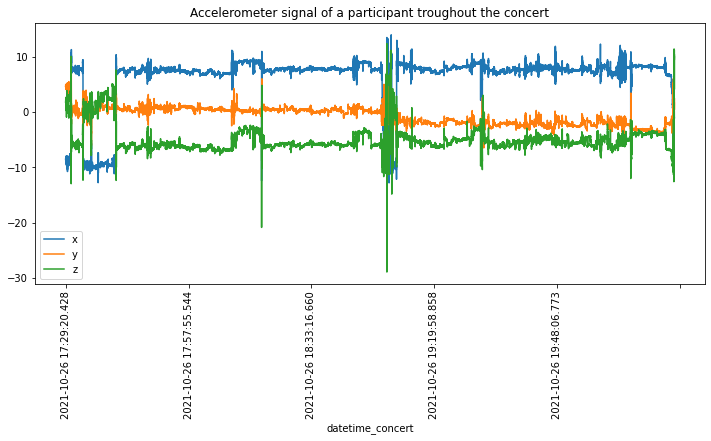

(['005093c6-7880-8728-1256-26822f05cfb0',
  '01393de0-e72e-5e80-f06f-8fdb5d0080cb',
  '01d00c32-d4dc-8ce6-353c-43143401adf3',
  '03fcbb15-14c6-b806-80b8-e2c161654dd6',
  '04e20480-91d3-cd85-3470-8656b157978f',
  '053bd8a0-2ed7-46e9-c088-8eaea2448192',
  '0ab9bf2b-a0c7-f823-0fde-6295eedb207e',
  '195bb6e0-55ec-d521-d69e-7bfa7cf86b9a',
  '1a9a903b-9524-f8c2-a943-81a108880e46',
  '1f6cba0e-36f5-b0c4-8117-00e1608ad7c3',
  '20395f60-420d-ad45-5d8e-11674c5d174c',
  '21a7c459-6987-302c-0945-5e6d691a6bb9',
  '24ae5e42-8442-d093-94b9-7ed4f9daf5dd',
  '25decfa4-d6e0-d757-722e-0f9db423fc2d',
  '278e797b-f81d-27bc-0ab5-7763b027915a',
  '28b71da8-4c96-556c-6281-c70af25020b6',
  '2b36bb42-2be3-9075-0de9-1cc9d3480a55',
  '2db31f15-6d47-da79-ab6a-02b55c6d065b',
  '2e904acd-adbb-900e-bb01-0a4d495ff553',
  '31f4e1a5-be17-3a37-ee86-1e215ffcb996',
  '3a82977f-1b44-11d0-04b5-d214deded928',
  '3aa57dd8-4d97-a01d-61ff-3139f2f2609b',
  '3c6f0d0b-57cb-9c6d-ee9d-ca34ed43fa7c',
  '3dec18f4-e83c-10a4-58d1-a41c583

In [5]:
# devices
dir_devices = DIR + 'Aligned/Hall/' # path to aligned accelerometer hall data
list_devices = np.array(os.listdir(dir_devices))
device_tags = [s.split('.')[0] for s in list_devices]

pd.read_csv(dir_devices + list_devices[-1]).plot(x='datetime_concert', y=['x','y','z'], figsize=(12,4.8), title='Accelerometer signal of a participant troughout the concert')
plt.xticks(rotation=90)
plt.show()

device_tags, len(device_tags)

In [6]:
# events
f_clappings = DIR + 'Concert_content/clapping_events.csv' # path to data file of clapping sections

df_clappings = pd.read_csv(f_clappings)
shift_concert_time = df_clappings.loc[0,'start_time'] - df_clappings.loc[0,'start_time_concert']

len_events = len(df_clappings.index)
list_events = range(0, len_events) # which events (sorted by occurrance)

df_clappings.loc[list_events,:]

,section_id,start_time_concert,start_time,end_time_concert,end_time,tag,clapping_type
0,0,-691.23,946.00,-674.10,963.13,"When musicians appear, before the introduction",1
1,1,-556.04,1081.19,-548.11,1089.12,Between Frederik & Simon talks,1
2,2,30.84,1668.07,40.38,1677.61,"After the introduction, before the concert begins",1
3,3,1610.37,3247.60,1651.88,3289.11,Beethoven,2
4,4,2004.46,3641.69,2016.13,3653.36,Musicians back to stage for Schnittke,1
5,5,3282.37,4919.60,3342.99,4980.22,Schnittke,2
6,6,5002.36,6639.59,5019.46,6656.69,Musicians back after intermission,1
7,7,6019.46,7656.69,6041.79,7679.02,Bach,2
8,8,6758.98,8396.21,6776.31,8413.54,Folk Music 1,3
9,9,6933.26,8570.49,6952.80,8590.03,Folk Music 2,3


# Create datasets for clapping sections

This section is to process the accelerometer data and create datasets for each clapping interval.


section: When musicians appear, before the introduction (-692230.0, -673100.0)
    0  : 005093c6-7880-8728-1256-26822f05cfb0
    1  : 01393de0-e72e-5e80-f06f-8fdb5d0080cb
    2  : 01d00c32-d4dc-8ce6-353c-43143401adf3
    3  : 03fcbb15-14c6-b806-80b8-e2c161654dd6
    4  : 04e20480-91d3-cd85-3470-8656b157978f
    5  : 053bd8a0-2ed7-46e9-c088-8eaea2448192
    6  : 0ab9bf2b-a0c7-f823-0fde-6295eedb207e
    7  : 195bb6e0-55ec-d521-d69e-7bfa7cf86b9a
    8  : 1a9a903b-9524-f8c2-a943-81a108880e46
    9  : 1f6cba0e-36f5-b0c4-8117-00e1608ad7c3
    10  : 20395f60-420d-ad45-5d8e-11674c5d174c
    11  : 21a7c459-6987-302c-0945-5e6d691a6bb9
    12  : 24ae5e42-8442-d093-94b9-7ed4f9daf5dd
    13  : 25decfa4-d6e0-d757-722e-0f9db423fc2d
    14  : 278e797b-f81d-27bc-0ab5-7763b027915a
    15  : 28b71da8-4c96-556c-6281-c70af25020b6
    16  : 2b36bb42-2be3-9075-0de9-1cc9d3480a55
    17  : 2db31f15-6d47-da79-ab6a-02b55c6d065b
    18  : 2e904acd-adbb-900e-bb01-0a4d495ff553
    19  : 31f4e1a5-be17-3a37-ee86-1e21

    16  : 2b36bb42-2be3-9075-0de9-1cc9d3480a55
    17  : 2db31f15-6d47-da79-ab6a-02b55c6d065b
    18  : 2e904acd-adbb-900e-bb01-0a4d495ff553
    19  : 31f4e1a5-be17-3a37-ee86-1e215ffcb996
    20  : 3a82977f-1b44-11d0-04b5-d214deded928
    21  : 3aa57dd8-4d97-a01d-61ff-3139f2f2609b
    22  : 3c6f0d0b-57cb-9c6d-ee9d-ca34ed43fa7c
    23  : 3dec18f4-e83c-10a4-58d1-a41c58306e19
    24  : 4328cccb-5ccb-0f74-37d8-5053dee5d75b
    25  : 46cd682f-1c28-bbef-1e2d-bd54a9ade9c3
    26  : 47bf00fa-1f9b-33e1-038b-0e0f19e96d93
    27  : 49472968-4242-c1b7-98c2-3a5c60c33d39
    28  : 551a3a14-12ed-f489-57f5-3817551bff74
    29  : 55b9d221-9d0d-7576-6461-d88b1293e435
    30  : 58f72607-481f-4cb5-4e92-2f7e5c2b6e73
    31  : 5fd385c0-0a1d-5008-39cf-9efbbd6f415a
    32  : 68cd78ff-286c-e9a3-dcfa-af2063147700
    33  : 69ae0c07-45dc-1a79-b81a-ddb8a020be3c
    34  : 6cfe2eb8-ea15-b8c9-053c-f6645e2d4e25
    35  : 6fe6188f-9350-28be-5d24-b146f1eb300b
    36  : 705ea43d-0c54-814c-3d61-64365f99d501
    37  : 740

    34  : 6cfe2eb8-ea15-b8c9-053c-f6645e2d4e25
    35  : 6fe6188f-9350-28be-5d24-b146f1eb300b
    36  : 705ea43d-0c54-814c-3d61-64365f99d501
    37  : 7406434c-c4d4-8f34-9895-5fb845cb9cb8
    38  : 77451c9f-ea66-2d70-21ac-c2c97a049b79
    39  : 77d1745b-a57f-d560-8642-eb1060dd6e1a
    40  : 7a5ae780-d9a2-3236-6c5d-813fabdbca9a
    41  : 7aebf51e-258a-b204-b1eb-5512df8e8ff9
    42  : 7f95d7ef-2dae-67c7-090a-96c4873abb36
    43  : 83ee5aa4-f96e-544d-8910-792b9e97f489
    44  : 8672e7d3-3fcc-d38c-3e3c-4261bc59e44f
    45  : 8717f492-0383-4421-1ff2-5375e6201edd
    46  : 881e7bc9-1dd8-7c3b-9e58-0050948457d8
    47  : 891551b7-70e2-2032-3ea0-3a3335b15901
    48  : 8da7ce5a-e617-5f5d-0880-00fb96112b2c
    49  : 9146d494-bdf6-9f1f-b23e-e66a53fb19a3
    50  : 9197305e-476d-1858-10a4-9658a5333b19
    51  : 966e0736-08a1-e03c-c4c3-b9d976dc992b
    52  : 981035ba-8cf0-6c34-97ca-fbd61266e8bf
    53  : 98ae5c8a-1fed-7d15-a922-9cc2bd9da9e0
    54  : 9ecdcced-debc-78df-3ace-7bc5ebbcb084
    55  : a6d

    52  : 981035ba-8cf0-6c34-97ca-fbd61266e8bf
    53  : 98ae5c8a-1fed-7d15-a922-9cc2bd9da9e0
    54  : 9ecdcced-debc-78df-3ace-7bc5ebbcb084
    55  : a6d70b79-d53c-cd6e-f822-cc96c1164d68
    56  : a9f02f46-cc41-1b66-75cf-e79a401874c1
    57  : aa29f63b-7ab9-5376-c677-d7051cdc684c
    58  : b140038b-ab82-7d7f-4710-f235a96dc4a5
    59  : b71de359-9d19-b08d-ba92-85005358b1b9
    60  : bfc2274e-acb2-21af-16d5-6ae9fac1593e
    61  : c32d3e7d-8ee6-0a11-b056-cb501edbfc7e
    62  : cc1ce8ab-eee9-f8fe-177e-6c9721798373
    63  : cd1ae6f8-b8cf-4a62-48a2-ff2590e4e4df
    64  : cf163fcc-b07d-4b8c-09c2-bb67dfa35767
    65  : d0c52eca-78e4-1f60-d365-41337c2844a2
    66  : d3445962-7716-057f-935c-11a3fb4653a3
    67  : d6a9af72-ff29-37ab-6c53-142c3cd002ab
    68  : d8f620dc-223e-0b8a-1a9c-c23b46444bbd
    69  : d90147ba-040d-d805-9ac0-ea1e76ddf6f6
    70  : e0f25cee-1127-b60a-4e29-c275c1358aaa
    71  : e95e41d4-b20c-560b-85df-6c815f20bc49
    72  : f03ce18b-d3d9-2639-d0b6-ebca90128a68
    73  : f04

    70  : e0f25cee-1127-b60a-4e29-c275c1358aaa
    71  : e95e41d4-b20c-560b-85df-6c815f20bc49
    72  : f03ce18b-d3d9-2639-d0b6-ebca90128a68
    73  : f045e08d-53b9-5e26-ad38-107564d919bc
    74  : f20847af-4c00-639e-5484-d705bd7a3437
    75  : f9945bf5-e47a-a404-3f45-d6954e78ce2a
    76  : fe0534f2-aaad-2afb-f5ba-79f8c2cc98b2
76  devices
section: Folk Music 2 (6931260.0, 6954800.000000001)
    0  : 005093c6-7880-8728-1256-26822f05cfb0
    1  : 01393de0-e72e-5e80-f06f-8fdb5d0080cb
    2  : 01d00c32-d4dc-8ce6-353c-43143401adf3
    3  : 03fcbb15-14c6-b806-80b8-e2c161654dd6
    4  : 04e20480-91d3-cd85-3470-8656b157978f
    5  : 053bd8a0-2ed7-46e9-c088-8eaea2448192
    6  : 0ab9bf2b-a0c7-f823-0fde-6295eedb207e
    7  : 195bb6e0-55ec-d521-d69e-7bfa7cf86b9a
    8  : 1a9a903b-9524-f8c2-a943-81a108880e46
    9  : 1f6cba0e-36f5-b0c4-8117-00e1608ad7c3
    10  : 20395f60-420d-ad45-5d8e-11674c5d174c
    11  : 21a7c459-6987-302c-0945-5e6d691a6bb9
    12  : 24ae5e42-8442-d093-94b9-7ed4f9daf5dd
    1

    10  : 20395f60-420d-ad45-5d8e-11674c5d174c
    11  : 21a7c459-6987-302c-0945-5e6d691a6bb9
    12  : 24ae5e42-8442-d093-94b9-7ed4f9daf5dd
    13  : 25decfa4-d6e0-d757-722e-0f9db423fc2d
    14  : 278e797b-f81d-27bc-0ab5-7763b027915a
    15  : 28b71da8-4c96-556c-6281-c70af25020b6
    16  : 2b36bb42-2be3-9075-0de9-1cc9d3480a55
    17  : 2db31f15-6d47-da79-ab6a-02b55c6d065b
    18  : 2e904acd-adbb-900e-bb01-0a4d495ff553
    19  : 31f4e1a5-be17-3a37-ee86-1e215ffcb996
    20  : 3a82977f-1b44-11d0-04b5-d214deded928
    21  : 3aa57dd8-4d97-a01d-61ff-3139f2f2609b
    22  : 3c6f0d0b-57cb-9c6d-ee9d-ca34ed43fa7c
    23  : 3dec18f4-e83c-10a4-58d1-a41c58306e19
    24  : 4328cccb-5ccb-0f74-37d8-5053dee5d75b
    25  : 46cd682f-1c28-bbef-1e2d-bd54a9ade9c3
    26  : 47bf00fa-1f9b-33e1-038b-0e0f19e96d93
    27  : 49472968-4242-c1b7-98c2-3a5c60c33d39
    28  : 551a3a14-12ed-f489-57f5-3817551bff74
    29  : 55b9d221-9d0d-7576-6461-d88b1293e435
    30  : 58f72607-481f-4cb5-4e92-2f7e5c2b6e73
    31  : 5fd

    28  : 551a3a14-12ed-f489-57f5-3817551bff74
    29  : 55b9d221-9d0d-7576-6461-d88b1293e435
    30  : 58f72607-481f-4cb5-4e92-2f7e5c2b6e73
    31  : 5fd385c0-0a1d-5008-39cf-9efbbd6f415a
    32  : 68cd78ff-286c-e9a3-dcfa-af2063147700
    33  : 69ae0c07-45dc-1a79-b81a-ddb8a020be3c
    34  : 6cfe2eb8-ea15-b8c9-053c-f6645e2d4e25
    35  : 6fe6188f-9350-28be-5d24-b146f1eb300b
    36  : 705ea43d-0c54-814c-3d61-64365f99d501
    37  : 7406434c-c4d4-8f34-9895-5fb845cb9cb8
    38  : 77451c9f-ea66-2d70-21ac-c2c97a049b79
    39  : 77d1745b-a57f-d560-8642-eb1060dd6e1a
    40  : 7a5ae780-d9a2-3236-6c5d-813fabdbca9a
    41  : 7aebf51e-258a-b204-b1eb-5512df8e8ff9
    42  : 7f95d7ef-2dae-67c7-090a-96c4873abb36
    43  : 83ee5aa4-f96e-544d-8910-792b9e97f489
    44  : 8672e7d3-3fcc-d38c-3e3c-4261bc59e44f
    45  : 8717f492-0383-4421-1ff2-5375e6201edd
    46  : 881e7bc9-1dd8-7c3b-9e58-0050948457d8
    47  : 891551b7-70e2-2032-3ea0-3a3335b15901
    48  : 8da7ce5a-e617-5f5d-0880-00fb96112b2c
    49  : 914

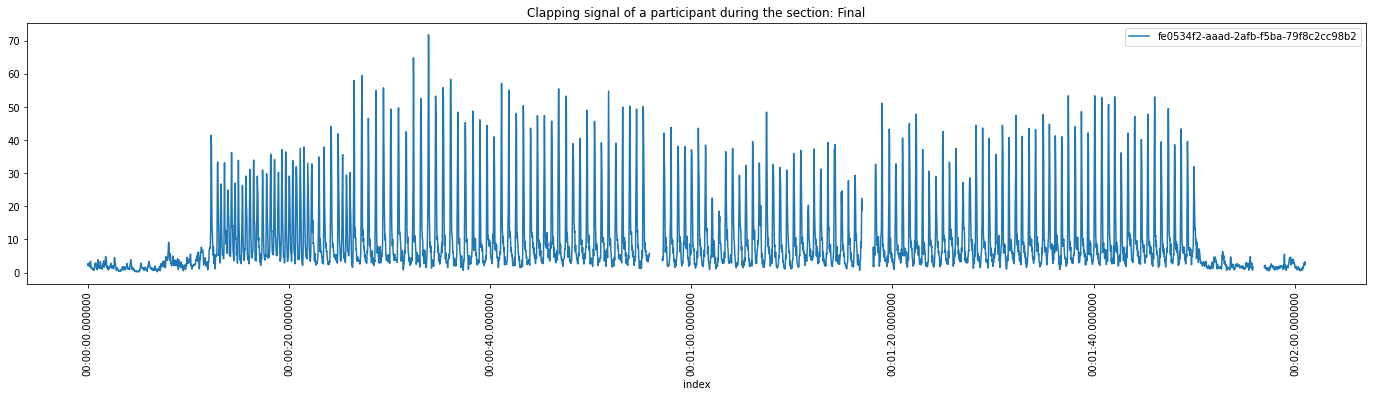

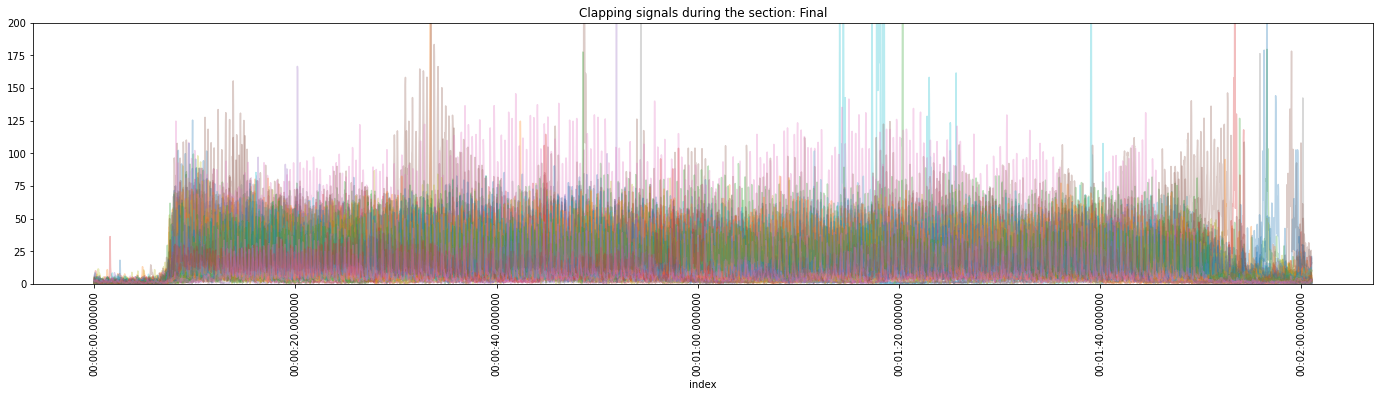

,005093c6-7880-8728-1256-26822f05cfb0,01393de0-e72e-5e80-f06f-8fdb5d0080cb,01d00c32-d4dc-8ce6-353c-43143401adf3,03fcbb15-14c6-b806-80b8-e2c161654dd6,04e20480-91d3-cd85-3470-8656b157978f,053bd8a0-2ed7-46e9-c088-8eaea2448192,0ab9bf2b-a0c7-f823-0fde-6295eedb207e,195bb6e0-55ec-d521-d69e-7bfa7cf86b9a,1a9a903b-9524-f8c2-a943-81a108880e46,1f6cba0e-36f5-b0c4-8117-00e1608ad7c3,...,d6a9af72-ff29-37ab-6c53-142c3cd002ab,d8f620dc-223e-0b8a-1a9c-c23b46444bbd,d90147ba-040d-d805-9ac0-ea1e76ddf6f6,e0f25cee-1127-b60a-4e29-c275c1358aaa,e95e41d4-b20c-560b-85df-6c815f20bc49,f03ce18b-d3d9-2639-d0b6-ebca90128a68,f045e08d-53b9-5e26-ad38-107564d919bc,f20847af-4c00-639e-5484-d705bd7a3437,f9945bf5-e47a-a404-3f45-d6954e78ce2a,fe0534f2-aaad-2afb-f5ba-79f8c2cc98b2
index,,,,,,,,,,,,,,,,,,,,,
00:00:00.000000,1.508962,0.751717,1.311696,NaN,0.227107,0.745280,0.838611,1.223528,3.607352,NaN,...,0.519429,NaN,1.078855,2.014070,1.266049,0.684809,4.476253,0.894492,0.839161,2.614916
00:00:00.020000,1.338763,0.953925,1.347451,NaN,0.726649,1.550522,1.588974,1.430142,2.958798,NaN,...,0.630064,NaN,2.597750,3.439909,0.996831,0.664641,3.062955,0.491208,1.594997,2.595511
00:00:00.040000,1.139509,0.880222,1.781533,NaN,0.805696,1.408689,1.396282,1.389464,3.201854,NaN,...,0.707460,NaN,3.962914,5.726702,0.996652,0.559767,2.519901,1.210250,1.567726,2.267201
00:00:00.060000,0.929010,0.877880,2.241210,NaN,0.781578,0.568864,0.991772,1.381282,4.127263,NaN,...,0.664765,NaN,4.265490,8.112032,1.010905,0.472408,2.404634,2.437044,1.863176,2.004653
00:00:00.080000,0.658353,1.294918,2.397461,NaN,0.924105,0.215651,0.942594,1.734101,4.169142,NaN,...,0.617727,NaN,3.489251,8.408194,0.892388,0.485348,2.208033,2.684083,2.458979,2.220688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:02:00.940000,0.941121,1.256331,0.467277,NaN,2.990463,3.004625,7.662223,NaN,2.917496,NaN,...,0.696388,NaN,12.500476,3.029946,1.085736,0.615877,NaN,1.319249,8.893998,2.396755
00:02:00.960000,1.022884,2.265336,0.443133,NaN,3.647553,2.886716,3.680119,NaN,2.610773,NaN,...,0.541555,NaN,11.509801,3.045182,1.532324,0.684124,NaN,1.197354,5.230123,2.311255
00:02:00.980000,1.190644,3.036756,0.526930,NaN,3.542186,2.465828,1.413937,NaN,1.418618,NaN,...,0.415311,NaN,10.453171,2.912880,2.380513,0.805709,NaN,1.052228,1.962266,2.844663


In [7]:
# process selected sections, save as csv files

Start_time = '2021-10-26 17:30:00+0000'
End_time   = '2021-10-26 20:30:00+0000'

# set standard timestamps in date time and millisecond floats
ts_dt = pd.date_range(pd.to_datetime(Start_time), pd.to_datetime(End_time), freq='20ms')
ts_ts = np.arange(pd.to_datetime(Start_time).timestamp(), pd.to_datetime(End_time).timestamp(), 0.02)*1000

for ev_idx in list_events:
  ev_in, ev_out, ev_type, ev_tag = df_clappings.loc[ev_idx, ['start_time_concert', 'end_time_concert', 'clapping_type', 'tag']]

  extend = EXTEND_WINDOW[ev_type]
  in_event_time = (ev_in - extend) * 10**3
  out_event_time = (ev_out + extend) * 10**3
  ts_ev = pd.date_range(start=pd.to_datetime(0), end=pd.to_datetime(abs(out_event_time - in_event_time), unit='ms'), freq='20ms')

  print('section:', ev_tag, (in_event_time, out_event_time))

  df_section = pd.DataFrame(index = ts_ev)
  
  # fill gaps with nans -> resampling vector norm -> plotting
  for dev_n, f in enumerate(list_devices):
    print('   ', dev_n, ' :', f.split('.')[0])

    # read device data
    df = pd.read_csv(dir_devices + f)
    
    # gap_nans
    # (function to detect the gaps longer than 100 and fill with nans)
    df['datetime_concert'] = (pd.to_datetime(df['timestamp'], unit='ms'))
    df_gapsafe = gap_nans(df, 100)
    df_gapsafe['datetime'] = (pd.to_datetime(df_gapsafe['timestamp'],unit='ms'))
    
    # resample to 50 Hz
    df_resampled = pd.DataFrame(index = ts_dt[:-1])
    cols = df_gapsafe.columns
    for col in cols:
        func = interp1d(df_gapsafe['timestamp'], df_gapsafe[col], fill_value='extrapolate')
        df_resampled[col] = func(ts_ts)

    # derivative, vector norm
    aud_df = pd.DataFrame(index = ts_dt[:-1], columns=['time_concert', f.split('.')[0]])
    aud_df.time_concert = df_resampled.time_concert
    norm = np.linalg.norm(df_resampled[['x','y','z']].diff().values,axis=1)

    # normalize
    if np.nanmedian(norm)>0:
        aud_df[f.split('.')[0]] = norm/np.nanmedian(norm)
    else:
        aud_df[f.split('.')[0]] = norm/np.nanmean(norm)
    
    # trim
    ## find the indexes with the closest time_concert
    in_event_index  = aud_df.time_concert.sub(in_event_time).abs().idxmin()
    out_event_index = in_event_index + pd.to_timedelta((ts_ev.shape[0]-1)*20, unit='ms')
    ## select event interval
    df_clap = aud_df.loc[in_event_index:out_event_index]

    # low pass filter
    T = 10.0        # sample period
    fs = 50.0       # Hz
    cutoff = 12.5   # cutoff frequency of the filter # Hz
    nyq = 0.5 * fs  # nyquist frequency
    order = 2 
    n = int(T * fs)
    data_raw = df_clap[~np.isnan(df_clap[f.split('.')[0]])]
    if data_raw[f.split('.')[0]].shape[0] > 10:
      data_filtered = butter_lowpass_filter(data_raw[f.split('.')[0]], cutoff, fs, order)
    else:
      #data_raw[f.split('.')[0]] = np.nan
      data_filtered = data_raw[f.split('.')[0]]

    df_clap.loc[data_raw.index, 'filtered'] = data_filtered

    # save clapping interval as df
    df_section[f.split('.')[0]] = df_clap['filtered'].values

    # end devices loop

  print(dev_n, ' devices')

  # save clapping section as csv file
  output_dir = DIR + 'Concert_content/clapping_motion/'
  if not os.path.exists(output_dir):
    os.mkdir(output_dir)
  df_section.index = pd.to_datetime(df_section.index).strftime('%H:%M:%S.%f')
  df_section.index.name = 'index'
  df_section.to_csv(output_dir + ev_tag.lower().replace(' ','_') + '_motion.csv')

  # end clappings loop

# plot
df_section.plot(y=-1, figsize=(24,4.8), rot=90, title='Clapping signal of a participant during the section: ' + ev_tag)
plt.xticks(rotation=90)
plt.show()

df_section.plot(alpha=0.3, legend=False, figsize=(24,4.8), rot=90, ylim=(0,200), title='Clapping signals during the section: ' + ev_tag)
plt.xticks(rotation=90)
plt.show()

df_section

# Focus on individual claps 

For further analysis, we extracted the time and amplitude values of each clap using peak picking and thresholding. This section outputs "trimmed" and "peaks" files, which contain individual clapping intervals and selected peaks respectively.

In [8]:
path_clapping_motion = DIR + 'Concert_content/clapping_motion/'
list_files = os.listdir(path_clapping_motion)
list_files

['after_the_introduction,_before_the_concert_begins_motion.csv',
 'a_short_clapping_between_speeches_motion.csv',
 'bach_motion.csv',
 'beethoven_motion.csv',
 'between_frederik_&_simon_talks_motion.csv',
 'final_motion.csv',
 'folk_music_1_motion.csv',
 'folk_music_2_motion.csv',
 'folk_music_3_motion.csv',
 'folk_music_4_motion.csv',
 'folk_music_5_motion.csv',
 'musicians_back_after_intermission_motion.csv',
 'musicians_back_to_stage_for_schnittke_motion.csv',
 'schnittke_motion.csv',
 'when_musicians_appear,_before_the_introduction_motion.csv']

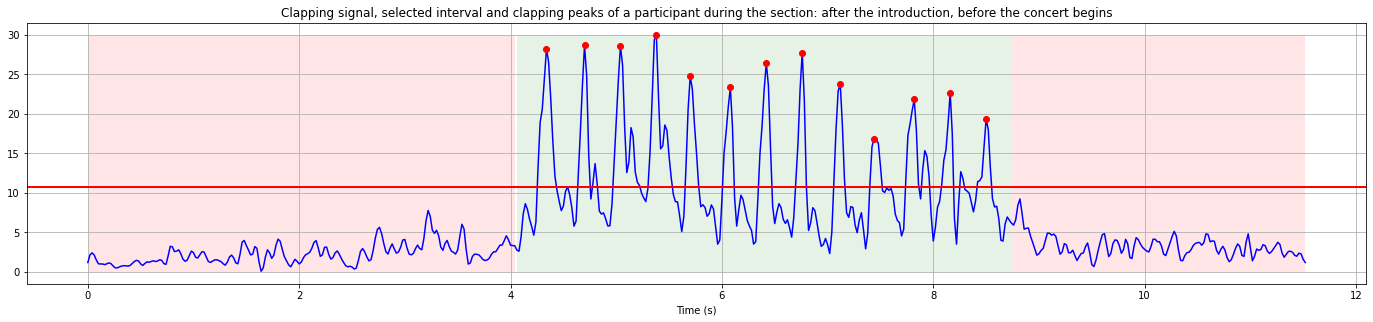

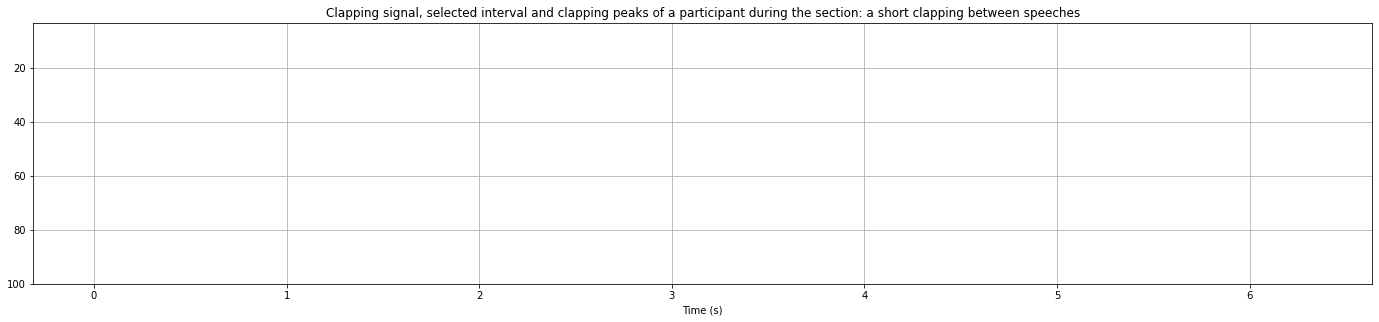

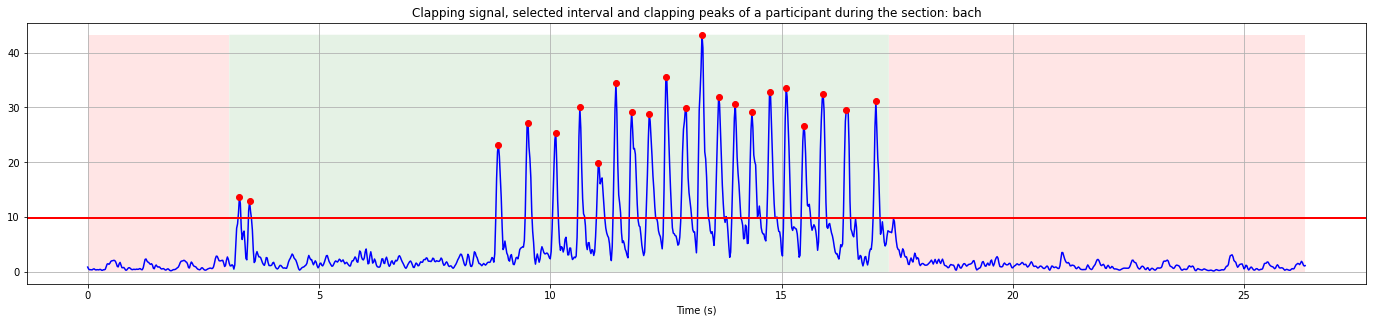

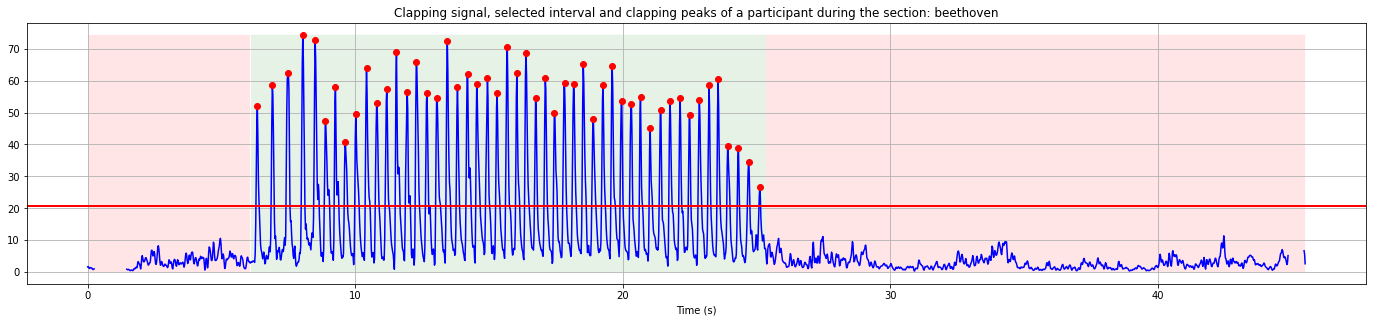

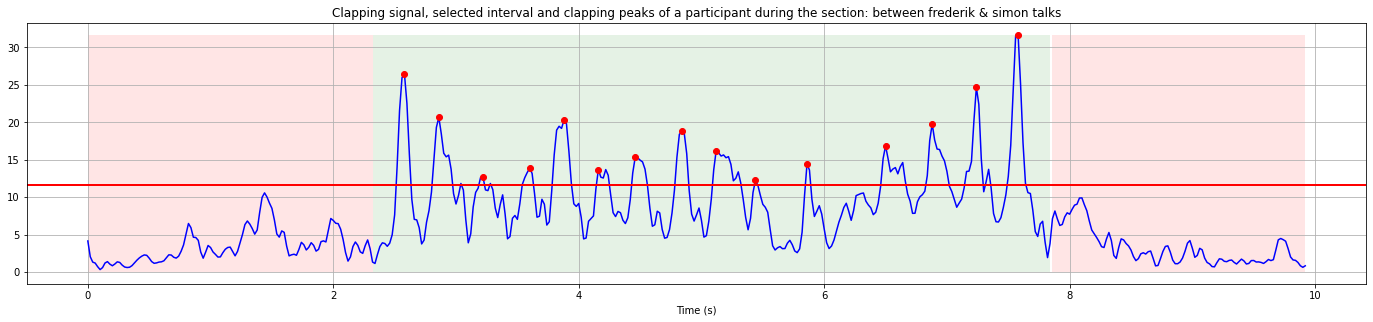

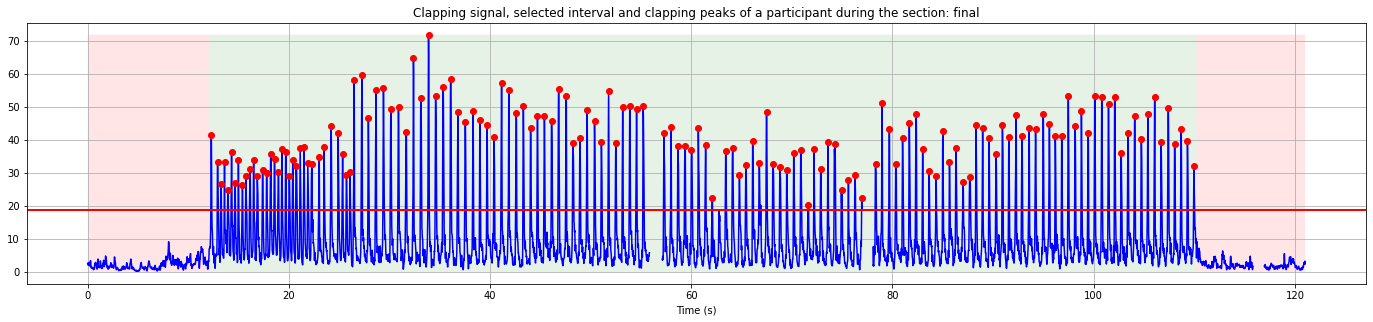

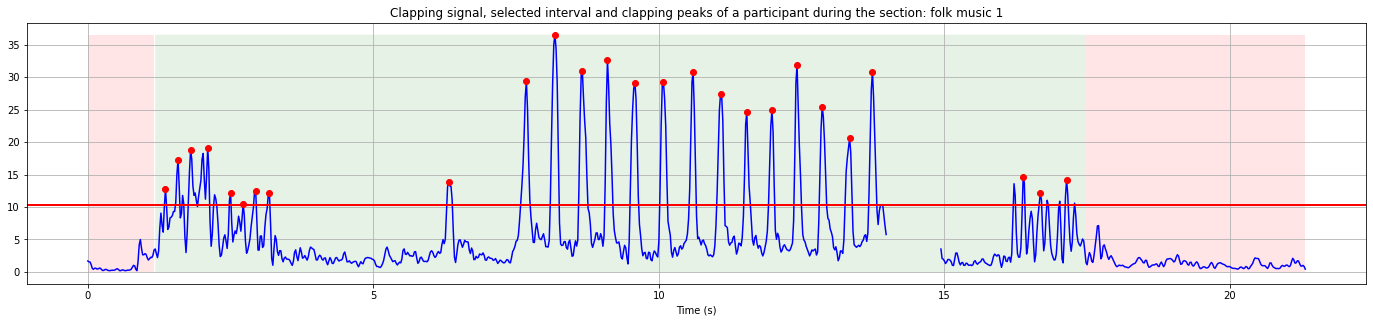

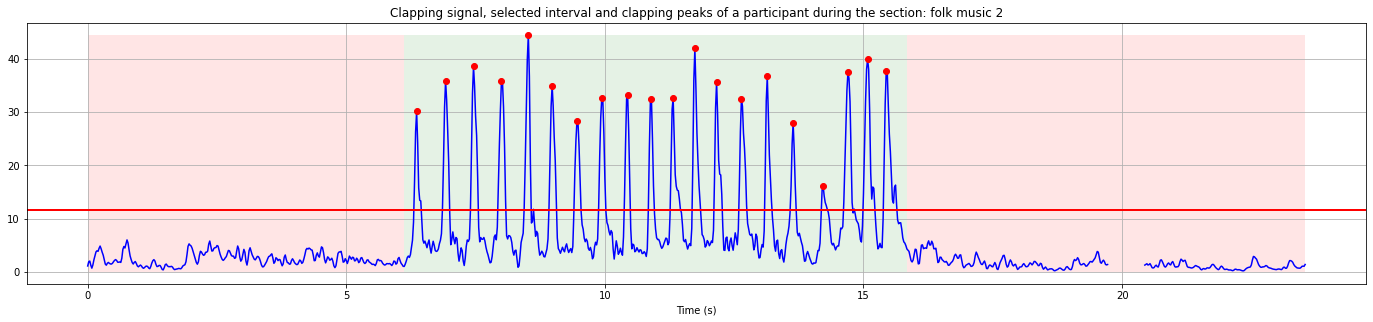

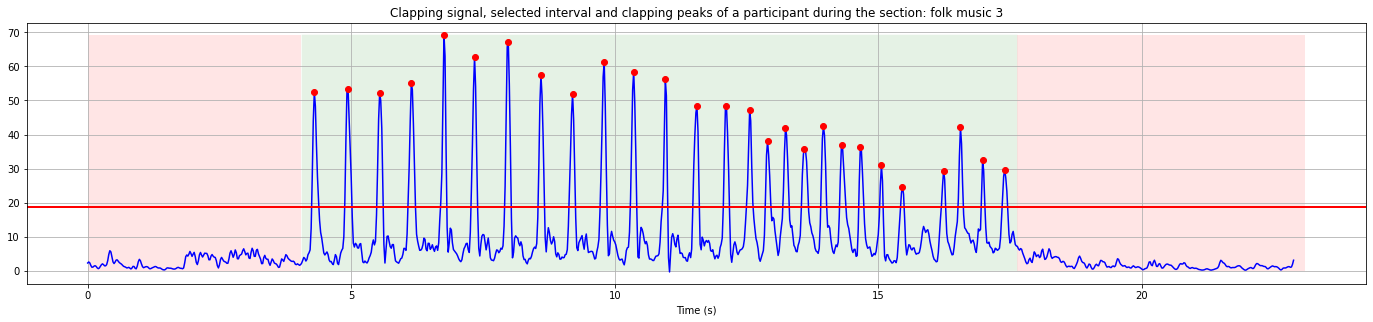

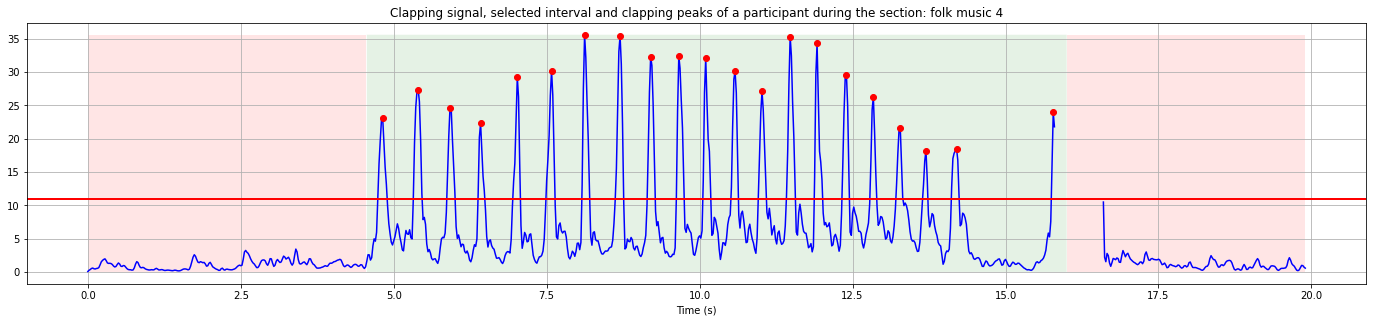

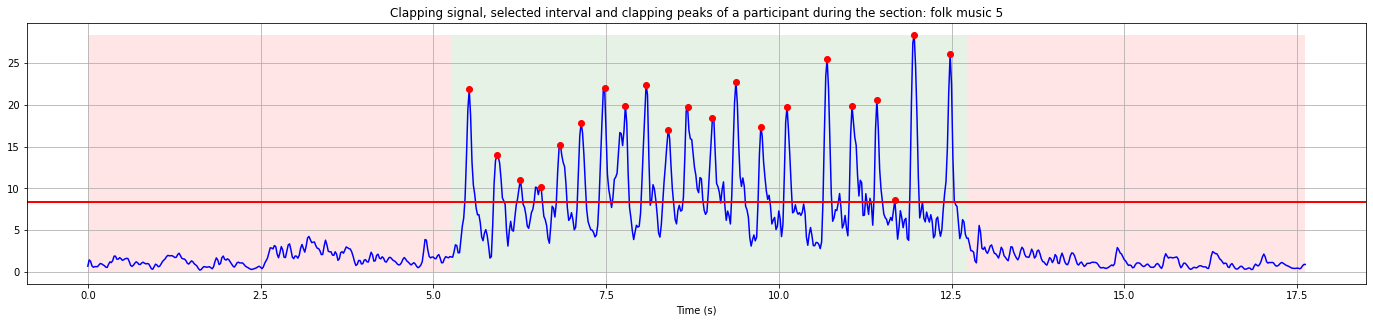

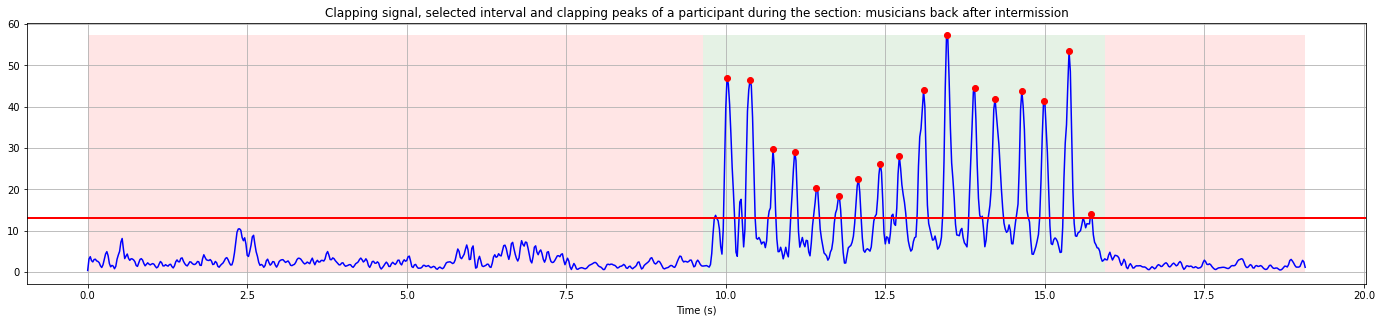

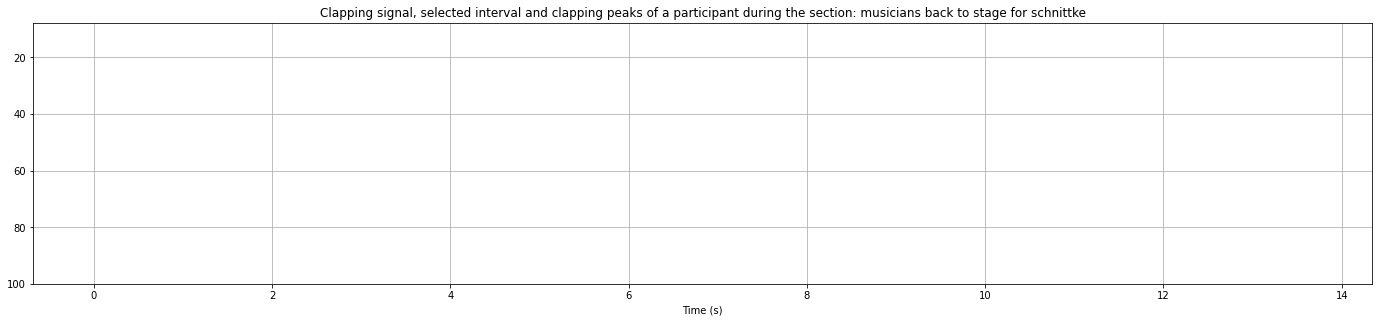

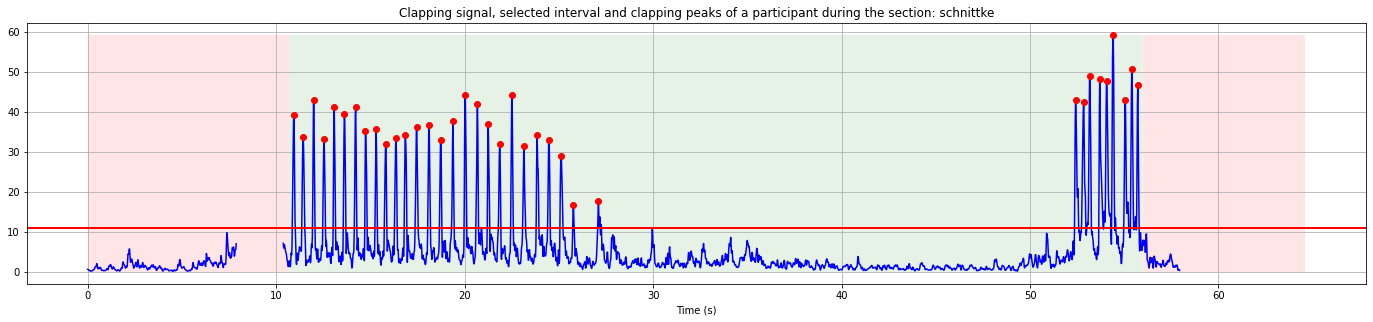

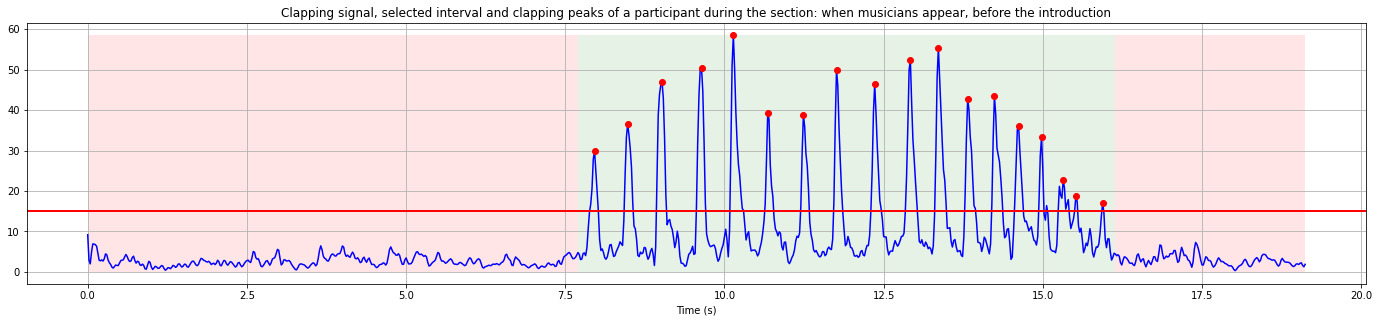

('C:/ritmo/CopenhagenMusicLab/Concert_content/clapping_trimmed/',
 ['after_the_introduction,_before_the_concert_begins_trimmed.csv',
  'a_short_clapping_between_speeches_trimmed.csv',
  'bach_trimmed.csv',
  'beethoven_trimmed.csv',
  'between_frederik_&_simon_talks_trimmed.csv',
  'final_trimmed.csv',
  'folk_music_1_trimmed.csv',
  'folk_music_2_trimmed.csv',
  'folk_music_3_trimmed.csv',
  'folk_music_4_trimmed.csv',
  'folk_music_5_trimmed.csv',
  'musicians_back_after_intermission_trimmed.csv',
  'musicians_back_to_stage_for_schnittke_trimmed.csv',
  'schnittke_trimmed.csv',
  'when_musicians_appear,_before_the_introduction_trimmed.csv'],
 'C:/ritmo/CopenhagenMusicLab/Concert_content/clapping_peaks/',
 ['after_the_introduction,_before_the_concert_begins_peaks.csv',
  'a_short_clapping_between_speeches_peaks.csv',
  'bach_peaks.csv',
  'beethoven_peaks.csv',
  'between_frederik_&_simon_talks_peaks.csv',
  'final_peaks.csv',
  'folk_music_1_peaks.csv',
  'folk_music_2_peaks.csv',
  

In [12]:
# for every clapping event
for f in list_files:
  # check if a csv file
  if not f.endswith('.csv'):
    continue

  # read data
  df_motion = pd.read_csv(path_clapping_motion + f, index_col=[0])
  df_motion.index = pd.Series(np.arange(0,len(df_motion.index))*0.02)
  df_ev = df_motion.copy()

  # create csv files
  df_trimmed = pd.DataFrame(index=df_ev.index)
  df_peaks = pd.DataFrame(index=df_ev.index, columns=df_ev.columns)
  df_rms = pd.DataFrame(columns=df_ev.columns)

  thr_list = []

  # for every participant
  for i, col in enumerate(df_ev.columns):
    # thresholding
    # Setting a threshold based on weighted average of average root
    # mean square and standart deviation.
    # Discard if std of signal is below std_thr
    rms = rms_signal(df_ev[col], SAMPLE_RATE, 4).dropna().replace(-1,np.nan)
    std = np.std(df_ev[col])
    thr = rms.mean()[0] + std*0.5
    thr = 0 if np.isnan(thr) else thr
    std_thr = 5
    thr = 0 if std<=std_thr else thr
    thr_list.append(thr)

    # save rms
    df_rms[col] = rms

    # in out pins
    # Extends the window 10 timestamps at both ends
    extend = 10 * 0.02
    if not (thr == 0):
      in_  = df_ev[df_ev[col]>thr][col].index.values[ 0] - extend
      out_ = df_ev[df_ev[col]>thr][col].index.values[-1] + extend
    else:
      in_  = 0
      out_ = 0
    df_ev.loc[:in_,col] = np.nan
    df_ev.loc[out_:,col] = np.nan

    # peaks
    peak_index_list = find_peaks(df_ev[col].values,distance=10)[0]
    s_plot = df_ev[col].iloc[peak_index_list]
    s_plot = s_plot[s_plot>thr]

    # trim first and last peaks, + extend
    # Extends the window 10 timestamps at both ends after trimming the
    # signal based on first and last claps
    if not s_plot.notna().sum() == 0:
      in_peak = s_plot.dropna().iloc[:1].index.values[0] - extend
      out_peak = s_plot.dropna().iloc[-1:].index.values[0] + extend
      in_peak_dt = pd.to_datetime(in_peak).strftime('%H:%M:%S.%f')
      out_peak_dt = pd.to_datetime(out_peak).strftime('%H:%M:%S.%f')
      df_ev.loc[:in_peak,col] = np.nan
      df_ev.loc[out_peak:,col] = np.nan

    # write to df
    df_trimmed[col] = df_ev[col].values
    df_peaks.loc[:,col] = np.nan
    df_peaks.loc[s_plot.index,col] = s_plot.values

    # end devices loop

  # save as csv files
  csv_trimmed_output_dir = DIR + 'Concert_content/clapping_trimmed/'
  if not os.path.exists(csv_trimmed_output_dir):
    os.mkdir(csv_trimmed_output_dir)
  df_trimmed_save = df_trimmed.copy()
  df_trimmed_save.index.name = 'index'
  df_trimmed_save.index = pd.date_range(0, periods=len(df_trimmed_save.index), freq='20ms').strftime('%H:%M:%S.%f')
  df_trimmed_save.to_csv(csv_trimmed_output_dir + f.replace('motion', 'trimmed'))

  csv_peaks_output_dir = DIR + 'Concert_content/clapping_peaks/'
  if not os.path.exists(csv_peaks_output_dir):
    os.mkdir(csv_peaks_output_dir)
  df_peaks_save = df_peaks.copy()
  df_peaks_save.index.name = 'index'
  df_peaks_save.index = pd.date_range(0, periods=len(df_peaks_save.index), freq='20ms').strftime('%H:%M:%S.%f')
  df_peaks_save.to_csv(csv_peaks_output_dir + f.replace('motion', 'peaks'))

  # plot
  i = -1 # participant idx
  plt.plot(df_motion.iloc[:,c], 'b-', df_peaks.iloc[:,c], 'ro')
  plt.fill_between(df_ev.index, df_peaks.iloc[:,c].max(),
                   where=(df_trimmed.index>=in_)&(df_trimmed.index<=out_), fc='g', alpha=0.1)
  plt.fill_between(df_ev.index, df_peaks.iloc[:,c].max(),
                   where=(df_trimmed.index<=in_)|(df_trimmed.index>=out_), fc='r', alpha=0.1)
  if thr == 0:
    plt.ylim(100)
  plt.axhline(thr_list[i], c='r', lw=2)
  plt.gcf().set_size_inches(24,4.8)

  plt.title('Clapping signal, selected interval and clapping peaks of a participant during the section: ' + ' '.join(f.split('_')[:-1]))
  plt.xlabel('Time (s)')
  plt.grid()
  plt.show()

  # end clappings loop

csv_trimmed_output_dir, os.listdir(csv_trimmed_output_dir), csv_peaks_output_dir, os.listdir(csv_peaks_output_dir)